# Gaussian Plume Modelling in Python: A Comprehensive Guide

Welcome to this tutorial on Gaussian Plume Modelling implemented in Python. Today, we will embark on a fascinating journey into the domain of atmospheric dispersion modelling, harnessing the power of Python to analyze and visualize complex environmental data. 

Gaussian Plume Modelling (GPM) is a quintessential method in atmospheric science, providing invaluable insights into the transport of pollutants in the atmosphere. The model, based on the Gaussian distribution, is used to predict the spread of pollutants from a continuous source, like a smokestack, into the surrounding area. 

In this tutorial, we will walk you through the steps to use Python for Gaussian Plume Modelling. We will make use of real-world data obtained from a measurement van equipped with a Quantum Cascade Laser (QCL). QCLs are instrumental in the detection and measurement of various chemical compounds in the atmosphere, making them a critical tool in our study.

Furthermore, we will leverage the power of Geopandas, a high-level Python library designed to work with geospatial data, to create compelling visualizations of our analysis. Geopandas combines the capabilities of pandas and shapely, providing a high-level interface for managing two-dimensional geometric shapes. 

By the end of this tutorial, you will be equipped to:

- Understand the basic principles of Gaussian Plume Modelling
- Import and analyze atmospheric data obtained from a QCL
- Implement Gaussian Plume Modelling in Python
- Use Geopandas for geospatial data manipulation and visualization
- Visualize your Gaussian Plume Model outputs using contour plots

Our journey through the Gaussian Plume Modelling will be a blend of theory and practice, helping you not only understand the mathematical underpinnings of the model but also its practical implementation in Python. So, let's dive into the exciting world of atmospheric dispersion modelling!

## Importing relevant Python tools

This work depends on the following Python tools:

1. **NumPy**: Short for Numerical Python, NumPy is a fundamental package for scientific computing in Python. It provides a high-performance multidimensional array object and tools for working with these arrays. NumPy is ideal for mathematical operations and forms the basis for more specialized libraries.

2. **Pandas**: Pandas is a powerful data manipulation library in Python, providing flexible data structures and data analysis tools. It's built on top of NumPy, and its key data structure, the DataFrame, is extremely useful when dealing with statistical data and data cleaning tasks.

3. **Matplotlib**: Matplotlib is a plotting library for Python. It provides both a quick way to visualize data from Python and publication-quality figures in many formats. Matplotlib is used for creating static, animated, and interactive plots in Python.

4. **GeoPandas**: Built on top of Pandas, GeoPandas is a Python library designed for handling geospatial data. It extends the datatypes used by pandas to allow spatial operations on geometric types, making it a powerful tool for geographic analyses and map plotting.

5. **Contextily**: Contextily is a Python package that allows easy access to tile maps from the internet. It's often used in conjunction with GeoPandas to provide a geographical context when plotting geospatial data.

6. **SciPy**: SciPy is a Python library used for scientific and technical computing. It builds on NumPy by adding a collection of algorithms and high-level commands for data manipulation and visualization. SciPy's key features include numerical integration, interpolation, optimization, linear algebra, and statistics.

Each of these libraries plays a crucial role in data analysis, visualization, and scientific computing in Python. Their combined use can cover a broad range of tasks in data science and geographic information science.

In [1]:
# Internal Python tools
import csv
import datetime
from pathlib import Path

# These tools have to been installed using Conda or pip.
import contextily as ctx
import geopandas as gpd
import matplotlib.colors
import matplotlib.dates
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from shapely.geometry import Point
from tqdm import tqdm

# My personal plot preferences for Matplotlib.
rcParams = {
    'xtick.labeltop': True,
    'xtick.top': True,
    'ytick.labelright': True,
    'ytick.right': True,
    'axes.grid': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'legend.loc': 'upper right',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'legend.title_fontsize': 'larger',
    'figure.figsize': (16,8)
}

plt.rcParams.update(rcParams)

C:\Users\bruingjd\AppData\Local\Temp\ipykernel_12012\1317789721.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Understanding Gaussian Plume Modelling

Gaussian Plume Modelling (GPM) serves as a foundational tool in the field of atmospheric dispersion modelling, helping us to predict how pollutants disperse in the ambient atmosphere. It's particularly relevant for assessing air quality and environmental impact from industrial sources, such as factories and power plants, which emit pollutants into the atmosphere.

The fundamental concept of Gaussian Plume Modelling hinges on the assumption that the pollutant dispersion follows a Gaussian distribution (also known as the normal distribution) in the crosswind and vertical directions. This assumption is reasonable in many real-world applications, given that the spread of pollutants is often influenced by random atmospheric turbulence, which tends to follow a normal distribution.

## The Basic Model

The Gaussian Plume Model is mathematically represented by the following equation:

```
C(x, y, z) = (Q / (2 * π * σy * σz * u)) * exp(-0.5 * (y / σy)^2) * (exp(-0.5 * ((z - H) / σz)^2) + exp(-0.5 * ((z + H) / σz)^2))
```

Where:

- `C(x, y, z)` is the pollutant concentration at a given location.
- `Q` is the pollutant emission rate (mass per unit time).
- `u` is the wind speed.
- `σy` and `σz` are the dispersion parameters (standard deviations of the pollutant distribution) in the crosswind and vertical directions, respectively. These parameters are typically derived from empirical relationships and depend on atmospheric stability conditions and the distance `x` from the source.
- `H` is the effective stack height, which is the physical stack height plus any additional height due to the plume's buoyancy.
- `x`, `y`, and `z` are the downwind, crosswind, and vertical distances, respectively, from the point source.

The above equation describes a three-dimensional plume where the pollutant concentration decreases as you move away from the plume centerline (both crosswind and vertically) and as you move downwind from the source (due to the dispersion and dilution of the pollutants).

In Python, we encode it as follows:

In [2]:
def calculate_concentration(Qs, wind_speed, sigma_y, sigma_z, dy, Zr, Hs, molecular_mass, Hm=None) -> float:
    """
    This function calculates the pollutant concentration at a given location based on the Gaussian Plume Model.
    
    Arguments
    ---------
    Qs : float
        Source strength in gram / second. Represents the rate at which the pollutant is being emitted.
        
    wind_speed : float
        Wind speed in m/s. This is the speed at which the wind is carrying the pollutant away from the source.
        
    sigma_y : float
        Plume width in m. Represents the standard deviation of the pollutant distribution in the crosswind direction.
        
    sigma_z : float
        Plume height in m. Represents the standard deviation of the pollutant distribution in the vertical direction.
        
    dy : float
        Distance perpendicular to the wind direction in m. This is the crosswind distance from the source.
        
    Zr : float
        Height of the measurement in m. This is the vertical distance from the ground to the point where the concentration is being measured.
        
    Hs : float
        Height of the source in m. This is the height at which the pollutant is being released.
        
    molecular_mass : float
        Molecular mass of the pollutant in g/mol. This is used to convert the calculated concentration from g/m^3 to parts per billion (ppb).
        
    Hm : float, optional
        Height of the mixing layer in m. Represents the height up to which the atmosphere is well-mixed. 
        If provided, the function will consider reflection of the plume from the top of the mixing layer. 
        No reflections are taken into account if not provided. 
    
    Returns
    -------
    float
        The calculated pollutant concentration at the given location in parts per billion (ppb).
    """
    ppb = 1e6  # Conversion factor from g/m^3 to ppb
    liter_per_mole_air = 22.36  # Volume occupied by one mole of air under standard conditions (in liters)
    
    A = Qs / (2 * np.pi * wind_speed * sigma_y * sigma_z)  # Pre-factor in the Gaussian plume equation
    B = np.exp(-dy**2 / (2 * sigma_y**2))  # Gaussian distribution factor in the crosswind direction
    C = 2 * sigma_z**2  # Factor used in the Gaussian distribution factors in the vertical direction
    D = np.exp(-(Zr - Hs)**2 / C)  # Gaussian distribution factor for the direct plume in the vertical direction
    E = np.exp(-(Zr + Hs)**2 / C)  # Gaussian distribution factor for the reflected plume in the vertical direction (reflection from the ground)
    F = 0 if Hm is None else np.exp(-(Zr - (2 * Hm - Hs))**2 / C)  # Gaussian distribution factor for the reflected plume in the vertical direction (reflection from the top of the mixing layer)
    
    return liter_per_mole_air * ppb * A * B * (D + E + F) / molecular_mass  # Calculate the pollutant concentration in ppb


We could visualize this model using Matplotlibs contourplot.
We simulate a N$_2$O source with an emission strength of 10 g/s, emitted at a source height of 10 m.

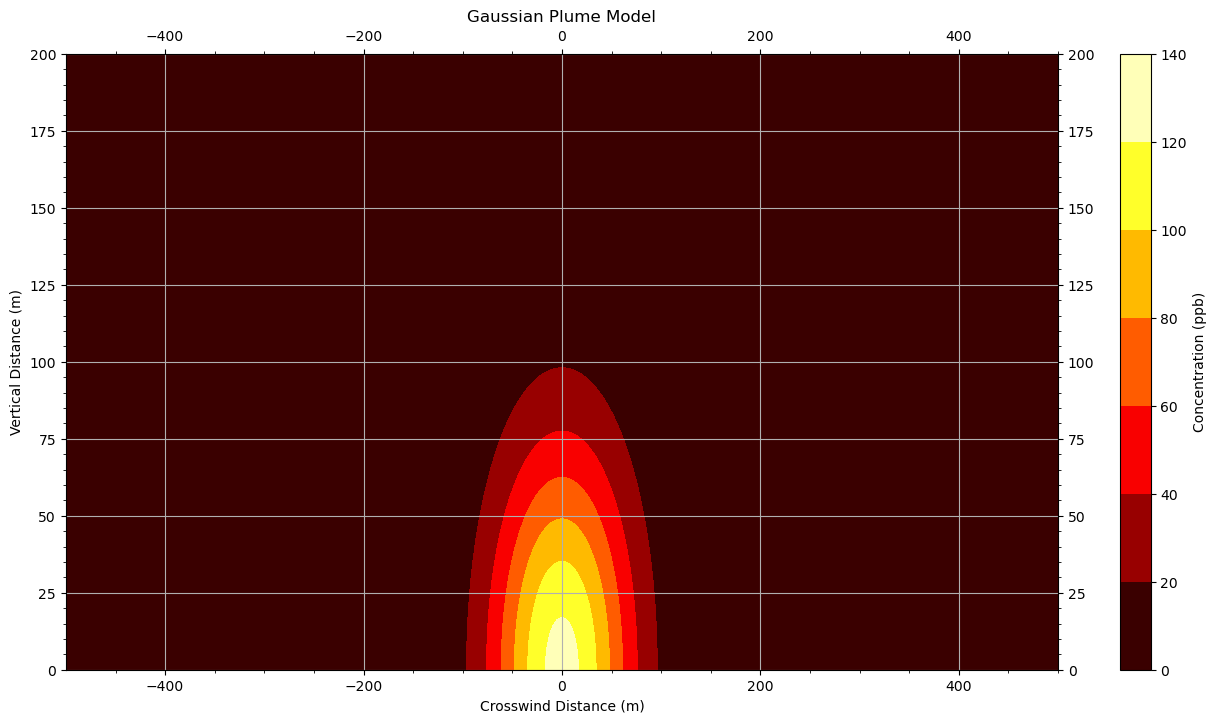

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid of points at which to calculate the concentration
x = np.linspace(-500, 500, 500)  # Crosswind distance in meters
z = np.linspace(0, 200, 200)  # Vertical distance in meters
X, Z = np.meshgrid(x, z)

# Define the parameters for the Gaussian plume model
Qs = 10  # Source strength in g/s
wind_speed = 5  # Wind speed in m/s
sigma_y = sigma_z = 50  # Dispersion parameters in m
Hs = 10  # Source height in m
molecular_mass = 44.013  # Molecular mass of N2O in g/mol

# Calculate the concentration at each point on the grid
C = np.zeros_like(X)
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        C[i, j] = calculate_concentration(Qs, wind_speed, sigma_y, sigma_z, X[i, j], Z[i, j], Hs, molecular_mass)

# Create a contour plot of the concentration
plt.figure()
plt.contourf(X, Z, C, cmap='hot')
plt.colorbar(label='Concentration (ppb)')
plt.title('Gaussian Plume Model')
plt.xlabel('Crosswind Distance (m)')
plt.ylabel('Vertical Distance (m)')
plt.show()

## Assumptions and Limitations

It's important to recognize the assumptions and limitations of the Gaussian Plume Model:

1. **Steady state:** The model assumes a steady-state condition, meaning the emission rate and meteorological conditions (like wind speed and direction, atmospheric stability) are constant over time.

2. **Homogeneous and flat terrain:** The model assumes the terrain over which the plume travels is flat and homogeneous, with no significant changes in the landscape or surface roughness.

3. **Gaussian distribution:** The model assumes the pollutant dispersion follows a Gaussian distribution in the crosswind and vertical directions, which may not always be the case, especially near the source or under specific atmospheric conditions.

4. **Effective stack height:** The model uses an effective stack height that accounts for the plume rise due to buoyancy, which can be difficult to estimate accurately.

Despite these assumptions, the Gaussian Plume Model has proven to be a useful and practical tool for preliminary assessments of air quality and for understanding the general behavior of pollutant dispersion in the atmosphere.

## Tracer location

In [4]:
## Importing tracer location
tracer = gpd.GeoSeries(
    Point(6.2994, 53.284), crs="WGS84" # GPS crs
).to_crs("EPSG:28992")                 # Rijkscoordinaten stelsel (see further)

## Import and analyze atmospheric data obtained from a QCL

We will now read the associated `qcl.csv` that contains the QCL measurements of $N_2O$ in Grijpskerken along with the geographical coordinates measured by the GPS in the van.
It has already been cleaned, and any non relevant parts are already left out.
We can read it in using the Pandas package.

In [5]:
df = pd.read_csv('qcl.csv', index_col=['datetime'])
df.index = pd.to_datetime(df.index, format='ISO8601')

display(df)

,x,y,N2O_ppb,comment,hour,transect
datetime,,,,,,
2019-03-29 10:54:12+00:00,6.299858,53.288950,0.000,11,11,0
2019-03-29 10:54:12.500000+00:00,6.299958,53.288800,0.000,11,11,0
2019-03-29 10:54:13+00:00,6.300008,53.288800,0.000,11,11,0
2019-03-29 10:54:13.500000+00:00,6.300057,53.288653,0.023,11,11,0
2019-03-29 10:54:14+00:00,6.300106,53.288653,0.017,11,11,0
...,...,...,...,...,...,...
2019-03-29 15:22:59+00:00,6.299993,53.288742,0.000,11,15,33
2019-03-29 15:22:59.250000+00:00,6.299966,53.288742,0.000,11,15,33
2019-03-29 15:22:59.500000+00:00,6.299940,53.288895,0.000,11,15,33


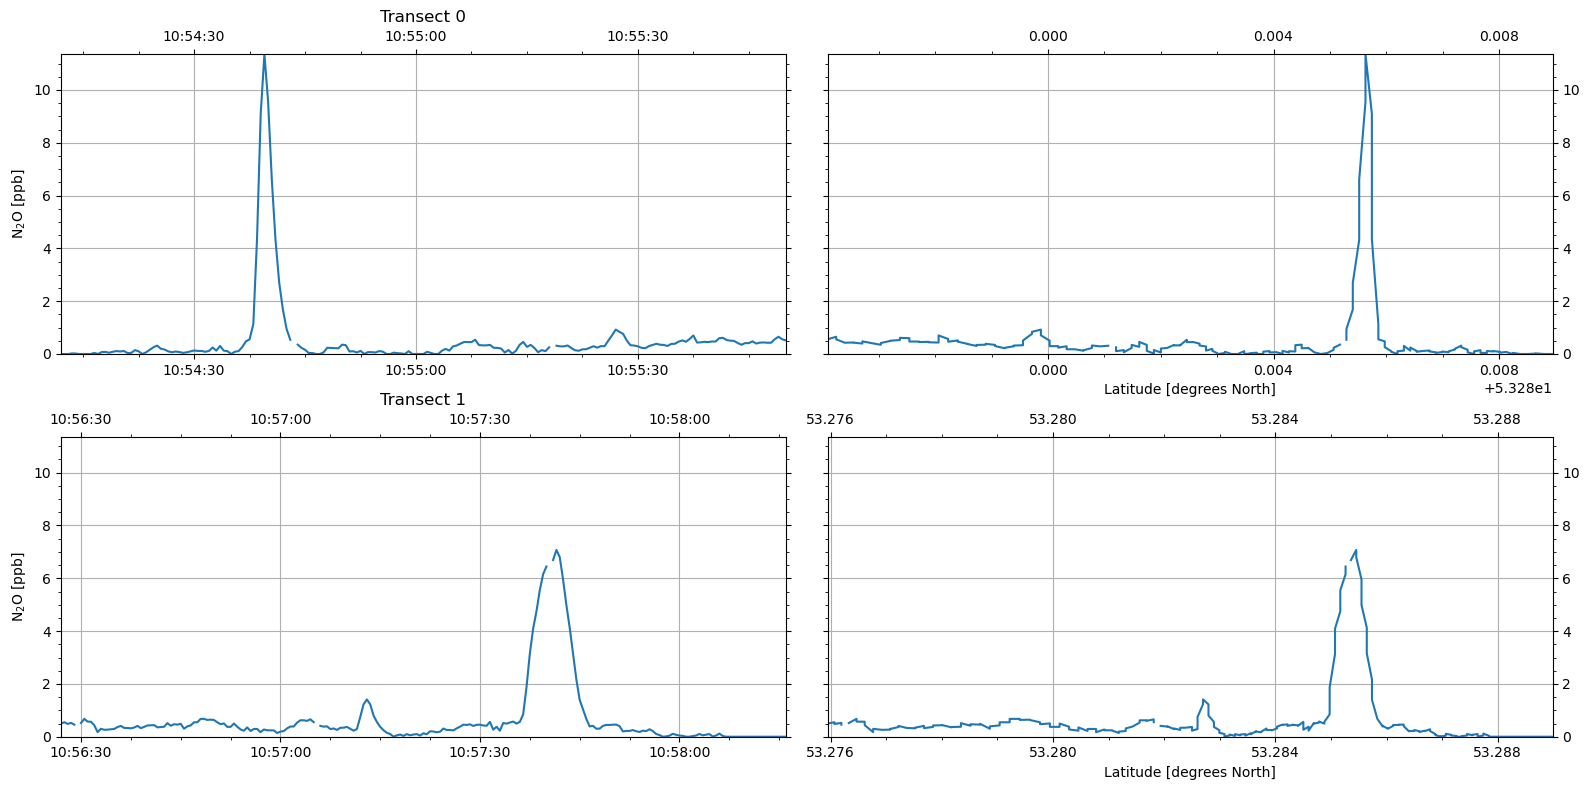

In [6]:
i = 0

fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, tight_layout=True)

df_ = df.query(f"transect == {i}")
axs[0,0].plot(df_['N2O_ppb'])
axs[0,0].xaxis.set_major_locator(matplotlib.dates.SecondLocator(bysecond=np.arange(0, 60, 30)))
axs[0,0].set(ylim=(0, None), ylabel='N$_2$O [ppb]', title=f"Transect {i}")

axs[0,1].plot(df_['y'], df_['N2O_ppb'])
axs[0,1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.004))
axs[0,1].set(xlabel='Latitude [degrees North]')

df_ = df.query(f"transect == {i+1}")
axs[1,0].plot(df_['N2O_ppb'])
axs[1,0].xaxis.set_major_locator(matplotlib.dates.SecondLocator(bysecond=np.arange(0, 60, 30)))
axs[1,0].set(ylabel='N$_2$O [ppb]', title=f"Transect {i+1}")

axs[1,1].plot(df_['y'], df_['N2O_ppb'])
axs[1,1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.004))
axs[1,1].set(xlabel='Latitude [degrees North]')

plt.show()

We can convert this Pandas DataFrame to a Geopandas dataframe and plot a map with the measurements.

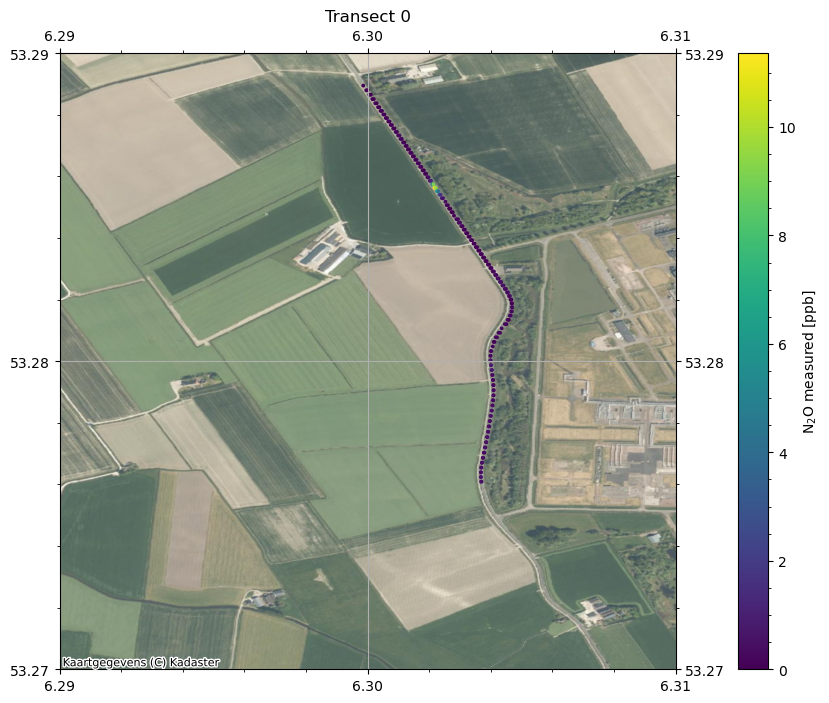

In [7]:
gdf = gpd.GeoDataFrame(
    df[['N2O_ppb', 'comment', 'hour', 'transect']], 
    geometry=gpd.points_from_xy(df.x, df.y), 
    crs='WGS84' # GPS Coordinate reference system
)

i = 0 # Transect number

fig, ax = plt.subplots()
gdf.query(f"transect == {i}").plot(ax=ax, column='N2O_ppb', legend=True, markersize=3, legend_kwds={'label': 'N$_2$O measured [ppb]'})
ax.set(xticks=[6.29, 6.3, 6.31], yticks=[53.27, 53.28, 53.29], xlim=(6.29, 6.31), ylim=(53.27, 53.29), title=f'Transect {i}')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto)
plt.show()

The Rijksdriehoeksstelsel or Rijkscoördinatenstelsel is the coordinate reference system (CRS) used by the Dutch government for spatial management and mapping in the Netherlands. The name "Rijksdriehoeksstelsel" translates to "national triangulation system".

This system is based on an equilateral triangle (hence the term "triangulation") with the top point located near the town of Amersfoort, which is known as the "Onze-Lieve-Vrouwentoren" or "Amersfoort coordinate". This point serves as the de facto origin of the Rijksdriehoeksstelsel system and is denoted as (155000, 463000).

The Rijksdriehoeksstelsel uses a Cartesian coordinate system, with the x-axis pointing to the west and the y-axis pointing to the north. The units of measurement are meters.

In terms of the EPSG code, the Rijksdriehoeksstelsel corresponds to EPSG:28992 (Amersfoort / RD New). If you're working with geospatial data in the Netherlands, this is likely the CRS you'll be using.

In [8]:
gdf = gdf.to_crs('EPSG:28992')

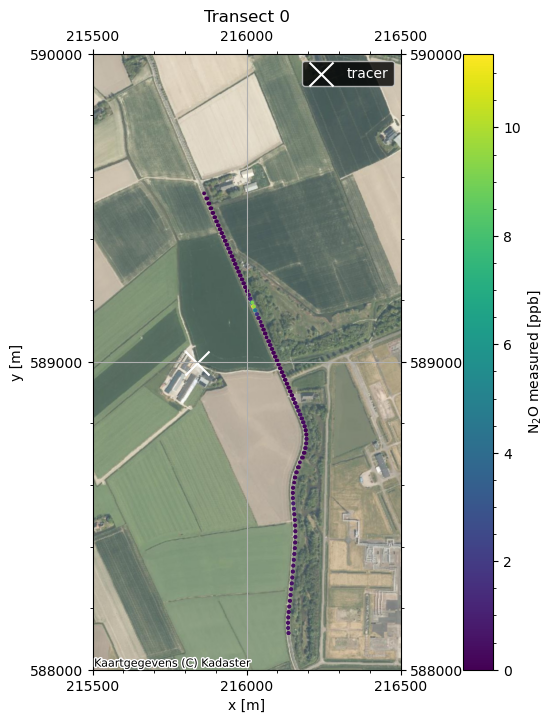

In [9]:
i = 0 # Transect number

fig, ax = plt.subplots()
gdf.query(f"transect == {i}").plot(ax=ax, column='N2O_ppb', legend=True, markersize=3, legend_kwds={'label': 'N$_2$O measured [ppb]'})
tracer.plot(ax=ax, marker='x', color='white', markersize=300, label='tracer')
ax.set(
    xlabel='x [m]',
    xticks=[215_500, 216_000, 216_500],
    ylabel='y [m]',
    yticks=[588_000, 589_000, 590_000], 
    title=f'Transect {i}'
)
ax.legend(facecolor='black', labelcolor='white')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto)
plt.show()

Or, as requested often by the EMSA Petten team, showing the peaks on top of the road:

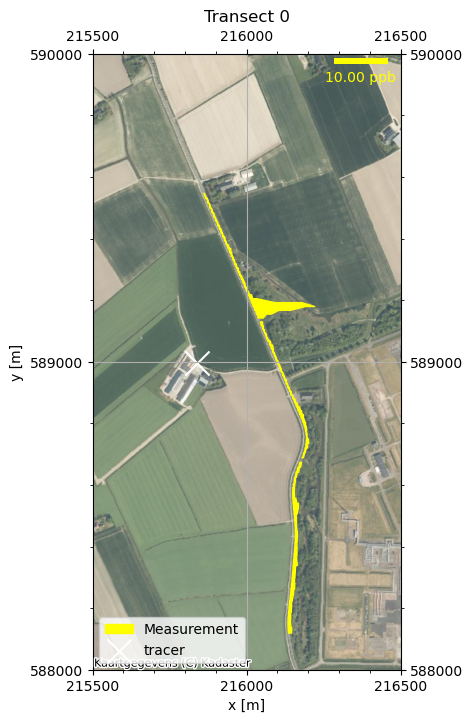

In [10]:
i = 0 # Transect number

gdf_ = gdf.query(f"transect == {i}")
fig, ax = plt.subplots()

v_max = gdf_['N2O_ppb'].max()
v_min = gdf_['N2O_ppb'].min()
norm = (gdf_['N2O_ppb'] - v_min) / (v_max - v_min)
factor = 200 # Maximum peak corresponds to 200 meter.

ax.fill_betweenx(y=gdf_.geometry.y, x1=gdf_.geometry.x, x2=gdf_.geometry.x + factor*norm, color='yellow', label='Measurement')
tracer.plot(ax=ax, marker='x', color='white', markersize=300, label='tracer')
ax.set(
    xlabel='x [m]',
    xticks=[215_500, 216_000, 216_500],
    ylabel='y [m]',
    yticks=[588_000, 589_000, 590_000], 
    title=f'Transect {i}'
)
scalebar = ScaleBar((v_max - v_min)/factor, label_formatter =  lambda x, y: f"{x:.2f} ppb", box_alpha=0, color='yellow')
ax.add_artist(scalebar)
ax.legend(loc='lower left')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto)

## Import Sonic data

In [11]:
sonic = pd.read_csv("sonic.csv", index_col=["datetime"])
sonic.index = pd.to_datetime(sonic.index, utc=True)
sonic

,U,V,W,T,Ufluc,Vfluc,Wfluc,Tfluc,Ubar,Winddir,Cdrag,U*,T*,tau,reystr,H,LE,L,corr(w/u),Hz
datetime,,,,,,,,,,,,,,,,,,,,
2019-03-29 10:50:00+00:00,-0.281,-3.746,0.043,8.232,0.715,0.417,0.128,0.191,3.757,235.7,0.007246,0.320,-0.222,0.128,-0.1023,90.133,-888.88,-32.159183,-0.14086,20.83
2019-03-29 11:00:00+00:00,0.508,-3.749,0.047,7.988,0.703,0.525,0.123,0.156,3.783,247.7,0.006641,0.308,-0.161,0.119,-0.0951,63.044,-888.88,-41.206031,-0.13319,20.83
2019-03-29 11:10:00+00:00,0.242,-3.669,0.030,8.113,0.559,0.452,0.104,0.228,3.678,243.8,0.005615,0.276,-0.222,0.095,-0.0759,77.634,-888.88,-23.885648,-0.13360,20.84
2019-03-29 11:20:00+00:00,1.731,-2.704,0.047,8.166,0.635,0.687,0.108,0.223,3.211,272.6,0.008615,0.298,-0.173,0.111,-0.0888,65.369,-888.88,-35.899463,-0.13786,20.83
2019-03-29 11:30:00+00:00,2.369,-2.454,0.054,7.930,0.460,0.469,0.096,0.081,3.411,284.0,0.007283,0.291,-0.094,0.106,-0.0847,34.683,-888.88,-63.025787,-0.18020,20.83
2019-03-29 11:40:00+00:00,1.427,-2.001,0.054,8.342,0.441,0.417,0.078,0.245,2.459,275.5,0.010899,0.257,-0.259,0.083,-0.0659,84.255,-888.88,-17.784949,-0.14714,20.83
2019-03-29 11:50:00+00:00,1.831,-1.616,0.082,8.448,0.362,0.360,0.064,0.240,2.444,288.6,0.007754,0.215,-0.255,0.058,-0.0463,69.437,-888.88,-12.717654,-0.12599,20.83
2019-03-29 12:00:00+00:00,2.083,-1.699,0.067,8.487,0.319,0.378,0.065,0.168,2.688,290.8,0.006869,0.223,-0.158,0.062,-0.0497,44.617,-888.88,-21.974621,-0.15235,20.83
2019-03-29 12:10:00+00:00,1.408,-1.589,0.043,8.403,0.366,0.417,0.056,0.094,2.124,281.5,0.009329,0.205,-0.128,0.053,-0.0421,33.319,-888.88,-22.952824,-0.11368,20.83


## Converts geographical coordinates into wind-relative coordinates
The geographical coordinates are converted into wind-relative coordinates with respect to the tracer location.

In [12]:
def geo2wind(x: np.ndarray[float], y: np.ndarray[float], x_origin: float, y_origin: float, wind_direction: float) -> tuple:
    """
    Converts geographical coordinates (Easting and Northing) into wind-relative coordinates (Downwind and Crosswind).

    The function first shifts the geographical coordinates such that the origin is at the reference point.
    Then, it computes the wind components given the wind direction.
    Next, it calculates the angle between the wind direction and the point in the shifted coordinate system.
    Finally, it uses trigonometric functions to calculate the Downwind and Crosswind distances.

    Parameters
    ----------
    x, y : float
        The Easting (x) and Northing (y) coordinates of the point.
    x_origin, y_origin: float
        The Easting (x_origin) and Northing (y_origin) coordinates of the reference point (origin).
    wind_direction : float
        The wind direction in degrees (0 degree is North, positive in the clockwise direction).

    Returns
    -------
    down_wind, cross_wind : tuple
        The Downwind and Crosswind distances (in the same units as x, y) from the origin to the point.
        The Downwind distance is set to NaN if it is negative (i.e., the point is upwind of the origin).
    """
    import metpy.calc
    from metpy.units import units

    # Shift coordinates such that the reference point (origin) is at (0,0)
    x_shifted = x - x_origin
    y_shifted = y - y_origin

    # Compute the wind components given the wind direction
    u, v = metpy.calc.wind_components(1 * units('m/s'), wind_direction * units.deg)

    # Calculate the dot product of the wind vector and the vector to the point
    dot_product = u.m*x_shifted + v.m*y_shifted

    # Calculate the Euclidean distance from the origin to the point
    distance = np.sqrt(x_shifted**2 + y_shifted**2)

    # Calculate the angle between the wind direction and the vector to the point
    # Small number is added to the denominator to avoid division by zero
    angle = np.arccos(dot_product / (distance + 1e-15))

    # Calculate the Downwind and Crosswind distances using trigonometric functions
    down_wind = np.cos(angle) * distance
    cross_wind = np.sin(angle) * distance

    # Set the Downwind distance to NaN if it is negative (i.e., the point is upwind of the origin)
    down_wind = np.where(down_wind >= 0, down_wind, np.nan)

    return down_wind, cross_wind


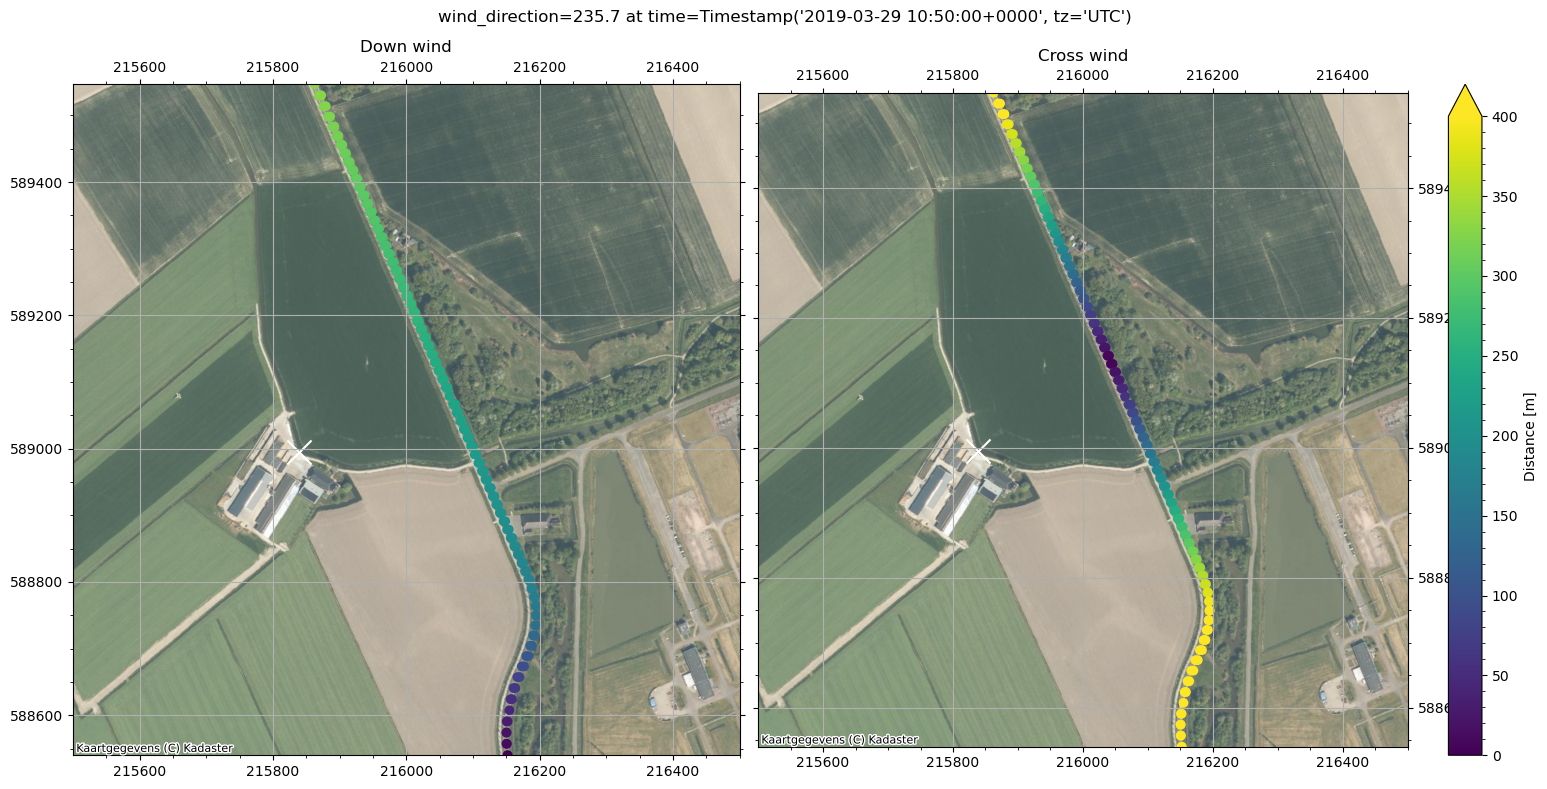

In [13]:
i = 0 # Transect number

gdf_ = gdf.query(f"transect == {i}")
time = gdf_.index[0].round('10min')
wind_direction = sonic.loc[time, 'Winddir']

down_wind, cross_wind = geo2wind(gdf_.geometry.x, gdf_.geometry.y, tracer.iloc[0].x, tracer.iloc[0].y, wind_direction)

fig, axs = plt.subplots(ncols=2, tight_layout=True, sharex=True, sharey=True)
fig.suptitle(f"{wind_direction=} at {time=}")

scatter = axs[0].scatter(gdf_.geometry.x, gdf_.geometry.y, c=down_wind, vmin=0, vmax=400)
tracer.plot(ax=axs[0], marker='x', markersize=300, color='white')
axs[0].set(title='Down wind', xlim=(215_500, 216_500))
ctx.add_basemap(ax=axs[0], crs=gdf.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto)

scatter = axs[1].scatter(gdf_.geometry.x, gdf_.geometry.y, c=cross_wind, vmin=0, vmax=400)
tracer.plot(ax=axs[1], marker='x', markersize=300, color='white')
axs[1].set(title='Cross wind')
ctx.add_basemap(ax=axs[1], crs=gdf.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto)

cbar = fig.colorbar(scatter, extend='max', ax=axs[1])
cbar.set_label('Distance [m]')

## Bringing it all together

In [14]:
from typing import Union, Optional
import numpy as np

def gaussian_dispersion_model(measurement_easting: Union[float, np.ndarray[float]], 
                              measurement_northing: Union[float, np.ndarray[float]],
                              *,
                              Qs: float, 
                              wind_direction: float,
                              wind_speed: float,
                              stability_class: Union[str, int],
                              roughness_length: float,
                              molecular_mass: float, 
                              measurement_height: Union[float, np.ndarray[float]] = 2,
                              source_easting: float = 0,
                              source_northing: float = 0,
                              source_height: float = 1,
                              mixing_layer_height: Optional[float] = None, 
                              ca: float = 0.53, 
                              cb: float = -0.22, 
                              offset_sigma_z: float = 0,
                              liter_per_mole_air: float = 22.36) -> Union[float, np.ndarray[float]]:
    """
    Calculate the pollutant concentration at a given location based on the Gaussian Plume Dispersion Model.

    Parameters
    ----------
    measurement_easting : float or np.ndarray[float]
        Easting of the measurement(s) in meters. If source_easting is not provided, should be relative with respect to the source.
    measurement_northing : float or np.ndarray[float]
        Northing of the measurement(s) in meters. If source_northing is not provided, should be relative with respect to the source.
    Qs : float
        Source strength in gram/second, rate at which the pollutant is being emitted.
    wind_direction: float
        Wind direction in degrees, ranging from 0 to 360, inclusive.
    wind_speed : float
        Wind speed at the source in m/s.
    stability_class : str or int
        Pasquill-Gifford stability class, single character from 'A' to 'E' or integer from 0 to 4, where 'A' or 0 is most stable.
    roughness_length: float
        Roughness length in meters.
    molecular_mass : float
        Molecular mass of the pollutant in g/mol.
    measurement_height : float or np.ndarray[float], optional
        Measurement height(s) above ground level in meters, default is 2.
    source_easting: float, optional
        Easting of the source in meters.
    source_northing: float, optional
        Northing of the source in meters.
    source_height : float, optional
        Height of the source above ground level in meters, default is 1.
    mixing_layer_height : float, optional
        Height of the mixing layer in meters, default is None. If provided, reflection from the top of the mixing layer is taken into account.
    ca : float, optional
        Exponent related to the rate of vertical spread of the plume, default is 0.53.
    cb : float, optional
        Exponent related to the rate of vertical spread of the plume, default is -0.22.
    offset_sigma_z : float, optional
        Offset for sigma_z calculation, default is 0.
    liter_per_mole_air: float, optional
        Volume occupied by one mole of air under standard conditions (in liters), default is 22.36.

    Returns
    -------
    float or np.ndarray[float]
        The calculated pollutant concentration(s) at the given location(s) in parts per billion (ppb).
    """
    import metpy.calc
    from metpy.units import units

    # Input validation
    if Qs <= 0:
        raise ValueError(f"Qs should be strictly positive, not {Qs}")
    if wind_direction < 0 or wind_direction > 360:
        raise ValueError(f"{wind_direction} should be between 0 and 360, inclusive. It was {wind_direction} however.")
    if wind_speed <= 0:
        raise ValueError(f"wind_speed should be strictly positive, not {wind_speed}")
    if isinstance(stability_class, int):
        if stability_class < 0 or stability_class > 4:
            raise ValueError(f"stability_class must be an integer from 0 to 4, not {stability_class}")
    elif isinstance(stability_class, str):
        if len(stability_class) != 1 or stability_class not in 'ABCDE':
            raise ValueError(f"stability_class must be a single character from 'A' to 'E', not {stability_class}")
        else:
            stability_class = ord(stability_class) - ord('A')
    else:
          raise ValueError(f"stability_class should be a single character from 'A' to 'E' or an integer from 0 to 4, not {type(stability_class)}")
    if roughness_length <= 0:
        raise ValueError(f"roughness_length should be strictly positive, not {roughness_length}")
    if molecular_mass <= 0:
        raise ValueError(f"molecular_mass should be strictly positive, not {molecular_mass}")
    if mixing_layer_height is not None and (mixing_layer_height < measurement_height or mixing_layer_height < source_height):
        raise ValueError(f"{mixing_layer_height=} should be higher than {measurement_height} and {source_height}.")

    # Constants for the dispersion calculation based on the stability class
    dispersion_constants = np.array([
        [1.94, .865, .28, .9],
        [1.36, .866, .23, .85],
        [.768, .897, .22, .8],
        [.47, .907, .2, .76],
        [.359, .902, .15, .73],
        [.238, .902, .12, .67]
    ])

    # Shift coordinates such that the reference point (origin) is at (0,0)
    x_shifted = measurement_easting - source_easting
    y_shifted = measurement_northing - source_northing

    # Compute the wind components given the wind direction
    u, v = metpy.calc.wind_components(1 * units('m/s'), wind_direction * units.deg)

    # Calculate the dot product of the wind vector and the vector to the point
    dot_product = u.m*x_shifted + v.m*y_shifted

    # Calculate the Euclidean distance from the origin to the point
    distance = np.sqrt(x_shifted**2 + y_shifted**2)

    # Calculate the angle between the wind direction and the vector to the point
    # Small number is added to the denominator to avoid division by zero
    angle = np.arccos(dot_product / (distance + 1e-15))

    # Calculate the Downwind and Crosswind distances using trigonometric functions
    down_wind = np.cos(angle) * distance
    cross_wind = np.sin(angle) * distance

    # Set the Downwind distance to NaN if it is negative (i.e., the point is upwind of the origin)
    down_wind = np.where(down_wind >= 0, down_wind, np.nan)
   
    # Calculate travel time (Tc) from source to measurement point
    Tc = np.clip(down_wind / (wind_speed * 3600), a_min=0.05, a_max=None)

    # Calculate plume spread in y (crosswind) direction
    sigma_y = dispersion_constants[stability_class,0] * down_wind**dispersion_constants[stability_class,1] * roughness_length**0.2 * Tc**0.35

    # Calculate plume spread in z (vertical) direction
    sigma_z = dispersion_constants[stability_class,2] * down_wind**dispersion_constants[stability_class,3] * (10*roughness_length)**(ca * down_wind**cb) + offset_sigma_z
    
    ppb = 1e6  # Conversion factor from g/m^3 to ppb
    
    A = Qs / (2 * np.pi * wind_speed * sigma_y * sigma_z)  # Pre-factor in the Gaussian plume equation
    B = np.exp(-cross_wind**2 / (2 * sigma_y**2))  # Gaussian distribution factor in the crosswind direction
    C = 2 * sigma_z**2  # Factor used in the Gaussian distribution factors in the vertical direction
    D = np.exp(-(measurement_height - mixing_layer_height)**2 / C)  # Gaussian distribution factor for the direct plume in the vertical direction
    E = np.exp(-(measurement_height + mixing_layer_height)**2 / C)  # Gaussian distribution factor for the reflected plume in the vertical direction (reflection from the ground)
    F = 0 if mixing_layer_height is None else np.exp(-(measurement_height - (2 * mixing_layer_height - source_height))**2 / C)  # Gaussian distribution factor for the reflected plume in the vertical direction (reflection from the top of the mixing layer)
    
    return liter_per_mole_air * ppb * A * B * (D + E + F) / molecular_mass  # Calculate the pollutant concentration in ppb



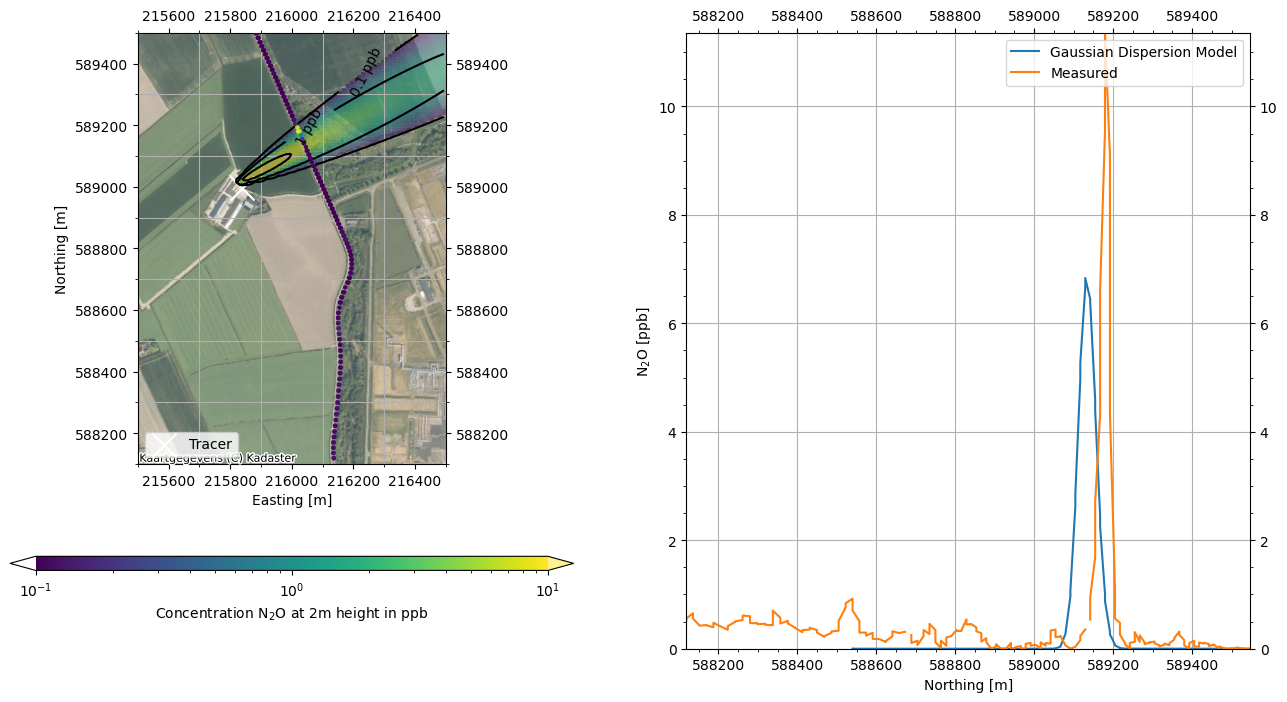

In [22]:
# Set initial parameters
stability_class = 'C'  # Atmospheric stability class
measurement_height = 2  # Height at which measurements are taken, in meters
Qs = 0.08  # Emission rate of the pollutant, in grams per second
source_height = 1  # Height of the source, in meters
roughness_length = 0.1  # Roughness length of the surface, as given by Katharina 
molecular_mass = 44.0128  # Molecular mass of Nitrous Oxide (N2O)
gaussian_dispersion_model_parameters = {
    'measurement_height': measurement_height,
    'Qs': Qs,
    'source_height': source_height,
    'wind_speed': wind_speed,
    'stability_class': stability_class,
    'roughness_length': roughness_length,
    'molecular_mass': molecular_mass,
    'source_easting': tracer.iloc[0].x,
    'source_northing': tracer.iloc[0].y
}

i = 0  # Transect number (used for segmenting data)

# Filter geodataframe for the current transect
gdf_ = gdf.query(f"transect == {i}")

# Round time to nearest 10 minutes and extract wind data for that time
time = gdf_.index[0].round('10min')
wind_direction = sonic.loc[time, 'Winddir']
wind_speed = sonic.loc[time, 'Ubar']

# Run Gaussian dispersion model on grid
fig, axs = plt.subplots(ncols=2)

### Left plot
gdf_.plot(ax=axs[0], column='N2O_ppb', vmin=.1, vmax=10, markersize=5, zorder=3) # Plot measured N2O concentration
tracer.plot(ax=axs[0], label='Tracer', marker='x', markersize=300, color='white') # Plot tracer location

# Generate grid for dispersion model visualization
y, x = np.mgrid[slice(588_100, 589_500, 10), slice(215_600, 216_400, 10)]
# Run Gaussian dispersion model on grid
model_result = gaussian_dispersion_model(x, y, **gaussian_dispersion_model_parameters)

# Set up colormap and color normalization
z = np.clip(np.nan_to_num(model_result), a_min=.01, a_max=None)
extent = [215_500, 216_500, 588_100, 589_500]
norm = matplotlib.colors.LogNorm(.1, 10)
cmap = matplotlib.colormaps['viridis']
cmap.set_under(alpha=0, color='white')

# Overlay dispersion model result on map
c = axs[0].imshow(z, extent=extent, origin='lower', norm=norm, alpha=.5, zorder=1, cmap=cmap)
cs = axs[0].contour(z, extent=extent, origin='lower', norm=norm, levels=[.1, 1, 10], colors='black', zorder=2)
axs[0].clabel(cs, inline=True, fontsize=10, fmt=lambda x: f'{int(x)} ppb' if x >= 1 else f'{x} ppb') # Add labels to the contour lines, specifying the format

# Add labels to the contour lines, specifying the format
ctx.add_basemap(axs[0], crs=gdf_.crs.to_string(), source=ctx.providers.nlmaps.luchtfoto, zorder=0)
axs[0].legend(loc='lower left')

# Set major and minor tick locations for x and y axes, enable grid, labels, and limits
axs[0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200))
axs[0].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(100))
axs[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200))
axs[0].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(100))
axs[0].grid(which='both')
axs[0].set(xlabel='Easting [m]', ylabel='Northing [m]', xlim=(215_500, 216_500), ylim=(588_100, 589_500))

# Set colorbar to the plot
cbar = fig.colorbar(c, extend='both', label=f'Concentration N$_2$O at {measurement_height}m height in ppb', orientation='horizontal', ax=axs[0], aspect=40)
cbar.solids.set(alpha=1)

### Right plot
model_result = gaussian_dispersion_model(gdf_.geometry.x, gdf_.geometry.y, **gaussian_dispersion_model_parameters) # Run Gaussian dispersion model
axs[1].plot(gdf_.geometry.y, model_result, label='Gaussian Dispersion Model') # Run Gaussian dispersion model
axs[1].plot(gdf_.geometry.y, gdf_['N2O_ppb'], label='Measured') # Run Gaussian dispersion model
axs[1].set(xlabel='Northing [m]', ylabel='N$_2$O [ppb]') # Run Gaussian dispersion model
axs[1].legend() # Run Gaussian dispersion model